# PostGIS on Python 3 and DBSCAN implementation
In this project, we use the dataset "animale" which contains a trajectory of 1189 points taken from a roe deer. 
The positions are expressed in projected coordinates (EPSG 3857).
We have to implement DBSCAN algorithm in order to find the most densely populated areas from the animal.
The result must be a list of the original points associated to a label. The labels denote the cluster each point belongs to. 
A label equals to 0 denotes a noisepoint.
<br>

Developers: [Luca Arrotta](https://github.com/lucaArrotta), 
[Cheick Tidiane Ba](https://github.com/BaCk7), 
[Giovanni Laganà](https://bitbucket.org/giolaga/).

![test](img/sr1.jpg)
![test](img/sr2.jpg)

***

### PostGIS on Python 3

Create the connection with the database.

In [1]:
import psycopg2
import pandas as pd

def create_connection():
    try:
        return psycopg2.connect("dbname='progetto' user='postgres' host='localhost' password='postgres' port=5433")
    except psycopg2.Error as e:
        print("Unable to connect to the database")
        print(e)

conn = create_connection()

<br>
Load the dataset from csv.

In [2]:
dataset = pd.read_csv("animale/animale.csv")
dataset.columns = ["animal", "id", "time", "x", "y"]
display(dataset.head(10))

,animal,id,time,x,y
0,767,1,2005-11-27 16:01:53,1.231569e+06,5.781499e+06
1,767,2,2005-11-28 00:03:00,1.231542e+06,5.781372e+06
2,767,3,2005-11-28 04:01:52,1.231879e+06,5.781536e+06
3,767,4,2005-11-28 08:01:24,1.231599e+06,5.781673e+06
4,767,5,2005-11-28 12:01:56,1.231634e+06,5.781679e+06
5,767,6,2005-11-28 16:01:24,1.231463e+06,5.781463e+06
6,767,7,2005-11-28 20:00:53,1.231446e+06,5.781406e+06
7,767,8,2005-11-29 00:02:20,1.231549e+06,5.781437e+06
8,767,9,2005-11-29 12:01:01,1.231638e+06,5.781744e+06
9,767,10,2005-11-29 16:01:47,1.231685e+06,5.781618e+06


<br>
Test: get data from a row of pandas dataframe.

In [3]:
for el in dataset.iterrows():
    row =  el[1]
    print(row['animal'],row['id'],row['time'],row['x'],row['y'])
    break;

767 1 2005-11-27 16:01:53 1231569.43843427 5781498.86921619


<br>
Create the animal table in the db. This SQL code is equivalent to the code generated by PostGIS when we import a shapefile.

In [4]:
cur = conn.cursor()
sql = """
        DROP TABLE IF EXISTS animale;
        
        CREATE TABLE animale
        (     
            gid SERIAL,           --EQUIVALENT TO gid integer NOT NULL DEFAULT nextval('animale_gid_seq'::regclass),
            animal character varying(254) COLLATE pg_catalog."default",
            id bigint,
            "time" character varying(254) COLLATE pg_catalog."default",
            x numeric,
            y numeric,
            geom geometry(Point, 3857),
            CONSTRAINT animale_pkey PRIMARY KEY (gid)
        );

        DROP INDEX IF EXISTS animale_geom_idx;

        CREATE INDEX animale_geom_idx
            ON animale USING gist
            (geom)
            TABLESPACE pg_default;
"""
cur.execute(sql)
conn.commit() 

<br>
Load the pandas dataframe into the db.

In [5]:
for el in dataset.iterrows():
    row =  el[1]    
    q = ''' INSERT INTO animale(animal,id,time,x,y,geom)
            VALUES({},{},'{}',{},{},ST_GeomFromText('POINT({} {})',3857));
    '''.format(row['animal'],row['id'],row['time'],row['x'],row['y'],row['x'],row['y'],)
    cur.execute(q)

conn.commit()

<br>
Decrement the gid values. In this way they start from 0 instead of 1. This is useful to simplify the implementation of DBSCAN algorithm.

In [6]:
cur = conn.cursor()
query = "UPDATE animale \
        SET gid = gid - 1"
cur.execute(query)
conn.commit()

<br>
Test 1: get the name of each db.

In [7]:
cur = conn.cursor()
cur.execute("""
    SELECT datname 
    FROM pg_database""")

rows = cur.fetchall()
print ("Databases:")

for row in rows:
    print("\t", row[0])

Databases:
	 postgres
	 esercitazioni
	 template1
	 template0
	 lab9
	 lab10
	 lab13
	 progetto


<br> 
Test 2: get 10 rows from table Animale(gid, animal, id, time, x, y, geom).

In [8]:
cur = conn.cursor()
cur.execute("""
    SELECT * 
    FROM animale
    ORDER BY id
    LIMIT 10""")
rows = cur.fetchall()

df = pd.DataFrame(rows)
df.columns = ["gid", "animal", "id", "time", "x", "y", "geom"]
display(df)

,gid,animal,id,time,x,y,geom
0,0,767,1,2005-11-27 16:01:53,1231569.43843427,5781498.86921619,0101000020110F0000733A3D70D1CA3241F13CA1B7FE0D...
1,1,767,2,2005-11-28 00:03:00,1231541.55290182,5781371.87100375,0101000020110F000043F98A8DB5CA32418386BEF7DE0D...
2,2,767,3,2005-11-28 04:01:52,1231879.10699376,5781535.53940703,0101000020110F00006CF1631B07CC324110A585E2070E...
3,3,767,4,2005-11-28 08:01:24,1231599.28318975,5781672.87767148,0101000020110F00009B1F7F48EFCA324100C52B382A0E...
4,4,767,5,2005-11-28 12:01:56,1231634.19298206,5781679.46496111,0101000020110F0000B445673112CB32413EECC1DD2B0E...
5,5,767,6,2005-11-28 16:01:24,1231462.87228573,5781463.40120825,0101000020110F00001B1E4EDF66CA32415E65ADD9F50D...
6,6,767,7,2005-11-28 20:00:53,1231446.10757042,5781406.2968917,0101000020110F00002CBC891B56CA32410B460093E70D...
7,7,767,8,2005-11-29 00:02:20,1231549.45658567,5781437.27709974,0101000020110F000068CCE274BDCA32418C00BC51EF0D...
8,8,767,9,2005-11-29 12:01:01,1231638.12256009,5781744.21619516,0101000020110F00001A19601F16CB32413924D60D3C0E...
9,9,767,10,2005-11-29 16:01:47,1231685.01032961,5781618.400493,0101000020110F000019F6A40245CB324164ADA1991C0E...


<br>
Test 3: get distances between point with gid=1 and all other points (considering only 10 rows).

In [9]:
cur = conn.cursor()
cur.execute("""
    SELECT a1.id, a2.id, ST_distance(a1.geom,a2.geom), a1.geom, a2.geom
    FROM animale a1, animale a2
    WHERE a1.id = 1 AND a2.id != 1
    ORDER BY a2.id
    LIMIT 10""")

rows = cur.fetchall()
df = pd.DataFrame(rows)
df.columns = ["id_point1", "id_point2", "distance", "geom1", "geom2"]
display(df)

,id_point1,id_point2,distance,geom1,geom2
0,1,2,130.023647,0101000020110F0000733A3D70D1CA3241F13CA1B7FE0D...,0101000020110F000043F98A8DB5CA32418386BEF7DE0D...
1,1,3,311.832198,0101000020110F0000733A3D70D1CA3241F13CA1B7FE0D...,0101000020110F00006CF1631B07CC324110A585E2070E...
2,1,4,176.549290,0101000020110F0000733A3D70D1CA3241F13CA1B7FE0D...,0101000020110F00009B1F7F48EFCA324100C52B382A0E...
3,1,5,191.854045,0101000020110F0000733A3D70D1CA3241F13CA1B7FE0D...,0101000020110F0000B445673112CB32413EECC1DD2B0E...
4,1,6,112.313506,0101000020110F0000733A3D70D1CA3241F13CA1B7FE0D...,0101000020110F00001B1E4EDF66CA32415E65ADD9F50D...
5,1,7,154.208097,0101000020110F0000733A3D70D1CA3241F13CA1B7FE0D...,0101000020110F00002CBC891B56CA32410B460093E70D...
6,1,8,64.752321,0101000020110F0000733A3D70D1CA3241F13CA1B7FE0D...,0101000020110F000068CCE274BDCA32418C00BC51EF0D...
7,1,9,254.779609,0101000020110F0000733A3D70D1CA3241F13CA1B7FE0D...,0101000020110F00001A19601F16CB32413924D60D3C0E...
8,1,10,166.266621,0101000020110F0000733A3D70D1CA3241F13CA1B7FE0D...,0101000020110F000019F6A40245CB324164ADA1991C0E...
9,1,11,146.108502,0101000020110F0000733A3D70D1CA3241F13CA1B7FE0D...,0101000020110F000078BE97A54CCB3241B9D68915EB0D...


<br>
Test 4: function which returns the distance matrix between all points.

In [10]:
def get_distance_matrix(conn):
    cur = conn.cursor()
    cur.execute("""
        SELECT a1.id, a2.id, ST_distance(a1.geom,a2.geom)
        FROM animale a1, animale a2
        WHERE a1.id != a2.id
        ORDER BY a1.id""")
    rows = cur.fetchall()
    df = pd.DataFrame(rows)
    df.columns = ["id_point1", "id_point2", "distance"]
    return df

display(get_distance_matrix(conn).head(10))

,id_point1,id_point2,distance
0,1,2,130.023647
1,1,3,311.832198
2,1,4,176.549290
3,1,5,191.854045
4,1,6,112.313506
5,1,7,154.208097
6,1,8,64.752321
7,1,9,254.779609
8,1,10,166.266621
9,1,11,146.108502


<br>
Test 5: create a table.

In [11]:
cur = conn.cursor()
sql = """DROP TABLE IF EXISTS test_table;

        CREATE TABLE test_table AS (
            SELECT *
            FROM animale
        )"""
cur.execute(sql)
conn.commit()

<br>
Test 6: add label column to the table.

In [12]:
cur.execute('ALTER TABLE test_table ADD "label" INTEGER')

labels = [0 for i in range(1189)]
for i, el in enumerate(labels):
    q = ''' UPDATE test_table 
            SET label = {} 
            WHERE id = {}
    '''.format(el, i+1)
    cur.execute(q)

conn.commit()

In [13]:
cur = conn.cursor()
cur.execute("""
    SELECT * 
    FROM test_table 
    ORDER BY id
    LIMIT 10""")
rows = cur.fetchall()
df = pd.DataFrame(rows)
df.columns = ["gid", "animal", "id", "time", "x", "y", "geom", "label"]
display(df)

,gid,animal,id,time,x,y,geom,label
0,0,767,1,2005-11-27 16:01:53,1231569.43843427,5781498.86921619,0101000020110F0000733A3D70D1CA3241F13CA1B7FE0D...,0
1,1,767,2,2005-11-28 00:03:00,1231541.55290182,5781371.87100375,0101000020110F000043F98A8DB5CA32418386BEF7DE0D...,0
2,2,767,3,2005-11-28 04:01:52,1231879.10699376,5781535.53940703,0101000020110F00006CF1631B07CC324110A585E2070E...,0
3,3,767,4,2005-11-28 08:01:24,1231599.28318975,5781672.87767148,0101000020110F00009B1F7F48EFCA324100C52B382A0E...,0
4,4,767,5,2005-11-28 12:01:56,1231634.19298206,5781679.46496111,0101000020110F0000B445673112CB32413EECC1DD2B0E...,0
5,5,767,6,2005-11-28 16:01:24,1231462.87228573,5781463.40120825,0101000020110F00001B1E4EDF66CA32415E65ADD9F50D...,0
6,6,767,7,2005-11-28 20:00:53,1231446.10757042,5781406.2968917,0101000020110F00002CBC891B56CA32410B460093E70D...,0
7,7,767,8,2005-11-29 00:02:20,1231549.45658567,5781437.27709974,0101000020110F000068CCE274BDCA32418C00BC51EF0D...,0
8,8,767,9,2005-11-29 12:01:01,1231638.12256009,5781744.21619516,0101000020110F00001A19601F16CB32413924D60D3C0E...,0
9,9,767,10,2005-11-29 16:01:47,1231685.01032961,5781618.400493,0101000020110F000019F6A40245CB324164ADA1991C0E...,0


<br>
Drop the table and close the connection.

In [14]:
cur = conn.cursor()
cur.execute('DROP TABLE test_table')
conn.commit()
conn.close()
cur.close()

***

### DBSCAN implementation (without temporal dimension)

Eps calibration.

In [15]:
def get_kth_neighbor(k, point, conn):
    '''
    returns a value containing the distance <point>-<kth-neighbor>
    '''
    cur = conn.cursor()
    query = "SELECT ST_distance(a1.geom,a2.geom) as dist\
            FROM animale a1, animale a2\
            WHERE a1.id = {}\
            ORDER BY dist\
            LIMIT 1 OFFSET {}".format(point, k)
    cur.execute(query)
    rows = cur.fetchall()
    return rows[0][0]


def plot_eps_calibration(k_distances):
    # plotting of k_dist pdf
    import matplotlib.pyplot as plt
    k_distances = sorted(k_distances)
    k_length_vector = list(range(0, len(k_distances)))
    plt.plot(k_length_vector, k_distances)
    plt.xlabel("points")
    plt.ylabel("distances")
    plt.show()
    
    
def get_kth_neighbors_distances(k, dataset, conn):
    k_distances = list()
    for point in dataset:
        k_distances.append(get_kth_neighbor(k, point, conn))
    plot_eps_calibration(k_distances)
    
    
def get_dataset_points():
    dataset_ids = list()
    for el in dataset.iterrows():
        row =  el[1]
        dataset_ids.append(row['id'])
    return dataset_ids


conn = create_connection()
get_kth_neighbors_distances(k=4, dataset=get_dataset_points(), conn=conn)

<Figure size 640x480 with 1 Axes>

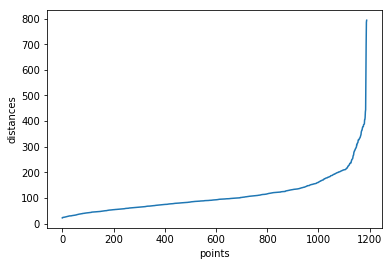

In [16]:
get_kth_neighbors_distances(k=20, dataset=get_dataset_points(), conn=conn)

<br>
Supporting functions for DBSCAN algorithm.

In [17]:
def get_len(conn):
    ''' 
    Returns the number of points in the "animale" dataset
    '''
    cur = conn.cursor()
    query = "SELECT count(*) as len\
            FROM animale"
    cur.execute(query)
    length = cur.fetchall()[0][0]
    return length


def get_core_points(eps, minPoints, conn):
    '''
    Returns a list with the id of each corepoint found
    '''
    cur = conn.cursor()
    query = "SELECT a1.gid\
            FROM animale a1, animale a2\
            WHERE ST_distance(a1.geom,a2.geom)<={}\
            GROUP BY a1.gid\
            HAVING count(*)>={}".format(eps, minPoints)
    cur.execute(query)
    rows = cur.fetchall()
    core_points_list = list()
    for row in rows:
        core_points_list.append(row[0])
    return core_points_list


def get_neighbors(eps, point):
    '''
    Returns a list with the neighbours of the input point
    '''
    cur = conn.cursor()
    query = "SELECT a2.gid\
            FROM animale a1, animale a2\
            WHERE ST_distance(a1.geom,a2.geom) <= {} and a1.gid = {}".format(eps, point)
    cur.execute(query)
    rows = cur.fetchall()
    neighbors_list = list()
    for row in rows:
        neighbors_list.append(row[0])
    return neighbors_list



def expand_cluster(point, cluster, eps, minPoints, labels):
    '''
    For each neighbor of "point", if it is "not visited" or a "noise point" we add it to the cluster. 
    Moreover, if this neighbor is a core point, we add also its neighborhood to the cluster
    '''    
    neighbors_list1 = get_neighbors(eps, point)
    for n_id in neighbors_list1:
        if labels[n_id] == 0 or labels[n_id] == -1:  # so the point is "not visited" or "noisepoint"
            labels[n_id] = cluster
            neighbors_list2 = get_neighbors(eps, n_id)
            if len(neighbors_list2) >= minPoints:
                neighbors_list1.extend(neighbors_list2)
    return

<br>
DBSCAN implementation (without temporal dimension). 

In [18]:
def dbscan(eps, minPoints, conn):
    len_dataset = get_len(conn)
    labels = [0 for i in range(len_dataset+1)]  # a list with a 0 for each dataset point
    core_points_list = get_core_points(eps, minPoints, conn)
    
    cluster = 0
    for i, el in enumerate(labels):  # i -> id of each point
        if el == 0:  # so the point is "not visited" 
            if i in core_points_list:  # so the point is a "corepoint"
                cluster += 1
                labels[i] = cluster
                expand_cluster(i, cluster, eps, minPoints, labels)
            else:  # so the point is a "noisepoint" or a "borderpoint"...if it is a "borderpoint" we reach it when we expand one of the clusters
                labels[i] = -1
    labels = [el if el!=-1 else 0 for el in labels ]  # transform all -1 in 0 for noise points
    return labels
    
    
l = dbscan(300, 20, conn)

<br>
Creation of a table with the result.

In [83]:
cur = conn.cursor()
sql = """DROP TABLE IF EXISTS result_table;
    
         CREATE TABLE result_table AS (
            SELECT *
            FROM animale
        )"""
cur.execute(sql)


cur.execute('ALTER TABLE result_table ADD "label" INTEGER')
for i, el in enumerate(l):
    q = ''' UPDATE result_table 
            SET label = {} 
            WHERE gid = {}
    '''.format(el, i)
    cur.execute(q)

conn.commit()

In [84]:
cur = conn.cursor()
cur.execute("""
    SELECT * 
    FROM result_table 
    ORDER BY gid
    """)
rows = cur.fetchall()
df = pd.DataFrame(rows)
df.columns = ["gid", "animal", "id", "time", "x", "y", "geom", "label"]
display(df.head(10))

,gid,animal,id,time,x,y,geom,label
0,0,767,1,2005-11-27 16:01:53,1231569.43843427,5781498.86921619,0101000020110F0000733A3D70D1CA3241F13CA1B7FE0D...,1
1,1,767,2,2005-11-28 00:03:00,1231541.55290182,5781371.87100375,0101000020110F000043F98A8DB5CA32418386BEF7DE0D...,1
2,2,767,3,2005-11-28 04:01:52,1231879.10699376,5781535.53940703,0101000020110F00006CF1631B07CC324110A585E2070E...,1
3,3,767,4,2005-11-28 08:01:24,1231599.28318975,5781672.87767148,0101000020110F00009B1F7F48EFCA324100C52B382A0E...,1
4,4,767,5,2005-11-28 12:01:56,1231634.19298206,5781679.46496111,0101000020110F0000B445673112CB32413EECC1DD2B0E...,1
5,5,767,6,2005-11-28 16:01:24,1231462.87228573,5781463.40120825,0101000020110F00001B1E4EDF66CA32415E65ADD9F50D...,1
6,6,767,7,2005-11-28 20:00:53,1231446.10757042,5781406.2968917,0101000020110F00002CBC891B56CA32410B460093E70D...,1
7,7,767,8,2005-11-29 00:02:20,1231549.45658567,5781437.27709974,0101000020110F000068CCE274BDCA32418C00BC51EF0D...,1
8,8,767,9,2005-11-29 12:01:01,1231638.12256009,5781744.21619516,0101000020110F00001A19601F16CB32413924D60D3C0E...,1
9,9,767,10,2005-11-29 16:01:47,1231685.01032961,5781618.400493,0101000020110F000019F6A40245CB324164ADA1991C0E...,1


<br>
Create the csv based on the result table.

In [85]:
df.to_csv("DBSCAN_no_time.csv", sep=',', index=False)

<br>
Close the connection.

In [86]:
conn.close()
cur.close()

<br>
Plot the result with matplotlib.

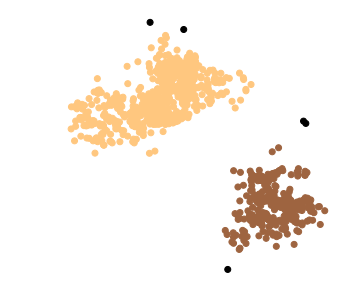

In [87]:
import matplotlib.pyplot as plt

xs = [tup[4] for tup in rows]
ys = [tup[5] for tup in rows]
ls = [tup[7] for tup in rows]

plt.figure(figsize=(5,5))
plt.scatter(xs, ys, c=ls, cmap="copper")
plt.axis('off')
plt.show()

<br>
Result from QGIS.

![test](img/screen1.PNG)

***

<br>

### Optional: DBSCAN with temporal dimension
Now, we consider also the time difference between each couple of points in the dataset.
<br>
Note: the following instruction allows us to get the time difference in days.
<br> _abs(EXTRACT(epoch from (a1.time::timestamp - a2.time::timestamp)))/(60\*60\*24)_ 

In [88]:
def get_core_points_with_time(eps, minPoints, timeDiff, conn):
    '''
    returns a list with the gid of each corepoint found
    '''
    cur = conn.cursor()
    query = "SELECT a1.gid\
            FROM animale a1, animale a2\
            WHERE ST_distance(a1.geom,a2.geom)<={}\
                AND abs(EXTRACT(epoch from (a1.time::timestamp - a2.time::timestamp)))/(60*60*24) < {}\
            GROUP BY a1.gid\
            HAVING count(*)>={}".format(eps, timeDiff, minPoints)
    cur.execute(query)
    rows = cur.fetchall()
    core_points_list = list()
    for row in rows:
        core_points_list.append(row[0])
    return core_points_list


def get_neighbors_with_time(eps, point, timeDiff):
    '''
    returns a list with the neighbours of the input point
    '''
    cur = conn.cursor()
    query = "SELECT a2.gid\
            FROM animale a1, animale a2\
            WHERE ST_distance(a1.geom,a2.geom) <= {} AND a1.gid = {} \
                AND abs(EXTRACT(epoch from (a1.time::timestamp - a2.time::timestamp)))/(60*60*24) < {}".format(eps, point, timeDiff)
    cur.execute(query)
    rows = cur.fetchall()
    neighbors_list = list()
    for row in rows:
        neighbors_list.append(row[0])
    return neighbors_list
    


def expand_cluster_with_time(point, cluster, eps, minPoints, labels, timeDiff):
    '''
    For each neighbor of "point", if it is "not visited" or a "noise point" we add it to the cluster. 
    Moreover, if this neighbor is a core point, we add also its neighborhood to the cluster
    '''  
    neighbors_list1 = get_neighbors_with_time(eps, point, timeDiff)
    for n_id in neighbors_list1:
        if labels[n_id] == 0 or labels[n_id] == -1:  # so the point is "not visited" or "noisepoint"
            labels[n_id] = cluster
            neighbors_list2 = get_neighbors_with_time(eps, n_id, timeDiff)
            if len(neighbors_list2) >= minPoints:
                neighbors_list1.extend(neighbors_list2)
    return

In [89]:
def dbscan_with_time(eps, minPoints, timeDiff, conn):
    len_dataset = get_len(conn)
    labels = [0 for i in range(len_dataset+1)]  # a list with a 0 for each dataset point
    core_points_list = get_core_points_with_time(eps, minPoints, timeDiff, conn)
    
    cluster = 0
    for i, el in enumerate(labels):  # i -> id of each point
        if el == 0:  # so the point is "not visited" 
            if i in core_points_list:  # so the point is a "corepoint"
                cluster += 1
                labels[i] = cluster
                expand_cluster_with_time(i, cluster, eps, minPoints, labels, timeDiff)
            else:  # so the point is a "noisepoint" or a "borderpoint"...if it is a "borderpoint" we reach it when we expand one of the clusters
                labels[i] = -1
    labels = [el if el!=-1 else 0 for el in labels ]  # transform all -1 in 0 for noise points
    return labels
    
    
conn = create_connection()
l = dbscan_with_time(eps=300, minPoints=20, timeDiff=10, conn=conn)

<br>
Function which creates the table with the result of the DBSCAN implementation considering the timestamps.

In [90]:
def create_table_result_with_time(conn, l):
    cur = conn.cursor()
    sql = """DROP TABLE IF EXISTS result_table_with_time;
    
             CREATE TABLE result_table_with_time AS (
                SELECT *
                FROM animale
            )"""
    cur.execute(sql)


    cur.execute('ALTER TABLE result_table_with_time ADD "label" INTEGER')
    for i, el in enumerate(l):
        q = ''' UPDATE result_table_with_time 
                SET label = {} 
                WHERE gid = {}
        '''.format(el, i)
        cur.execute(q)

    conn.commit()
    
create_table_result_with_time(conn, l)

<br>
Function which returns the rows of the result table.

In [91]:
def get_result_table_rows(conn):
    cur = conn.cursor()
    cur.execute("""
        SELECT gid, animal, id, EXTRACT(epoch from (time::timestamp))/(60*60*24) as time, x, y, geom, label
        FROM result_table_with_time 
        """)
    rows = cur.fetchall()
    return rows
    
rows = get_result_table_rows(conn)
df = pd.DataFrame(rows)
df.columns = ["gid", "animal", "id", "time", "x", "y", "geom", "label"]
display(df.head(10))

,gid,animal,id,time,x,y,geom,label
0,0,767,1,13114.667975,1231569.43843427,5781498.86921619,0101000020110F0000733A3D70D1CA3241F13CA1B7FE0D...,1
1,1,767,2,13115.002083,1231541.55290182,5781371.87100375,0101000020110F000043F98A8DB5CA32418386BEF7DE0D...,0
2,2,767,3,13115.167963,1231879.10699376,5781535.53940703,0101000020110F00006CF1631B07CC324110A585E2070E...,0
3,3,767,4,13115.334306,1231599.28318975,5781672.87767148,0101000020110F00009B1F7F48EFCA324100C52B382A0E...,1
4,4,767,5,13115.501343,1231634.19298206,5781679.46496111,0101000020110F0000B445673112CB32413EECC1DD2B0E...,1
5,5,767,6,13115.667639,1231462.87228573,5781463.40120825,0101000020110F00001B1E4EDF66CA32415E65ADD9F50D...,0
6,6,767,7,13115.833947,1231446.10757042,5781406.2968917,0101000020110F00002CBC891B56CA32410B460093E70D...,0
7,7,767,8,13116.001620,1231549.45658567,5781437.27709974,0101000020110F000068CCE274BDCA32418C00BC51EF0D...,0
8,8,767,9,13116.500706,1231638.12256009,5781744.21619516,0101000020110F00001A19601F16CB32413924D60D3C0E...,1
9,9,767,10,13116.667905,1231685.01032961,5781618.400493,0101000020110F000019F6A40245CB324164ADA1991C0E...,1


<br>
Create the csv based on the result table.

In [92]:
df.to_csv("DBSCAN_with_time.csv", sep=',', index=False)

<br>
Close the connection.

In [93]:
conn.close()
cur.close()

<br>
Function which plot the 3D representation of the data, after clustering.

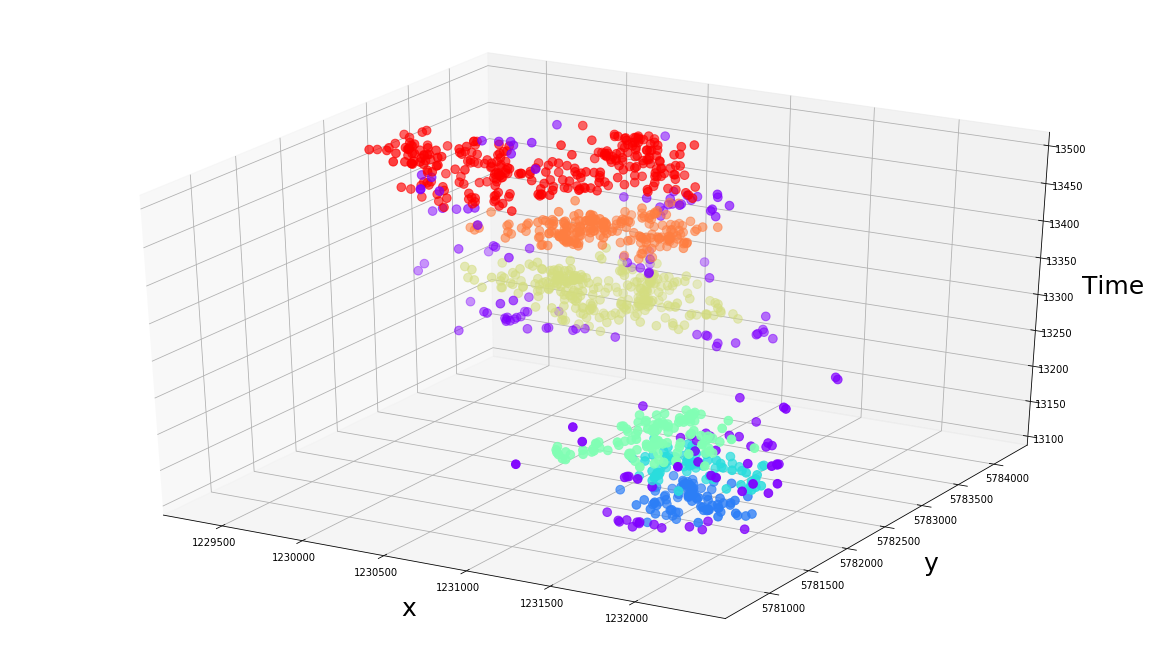

In [94]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def plot_3D(rows):
    xs = [tup[4] for tup in rows]
    ys = [tup[5] for tup in rows]
    zs = [tup[3] for tup in rows]
    ls = [tup[7] for tup in rows]

    fig = plt.figure(figsize=(16,9))
    ax = Axes3D(fig)
    ax.scatter(xs, ys, zs, c=ls, cmap="rainbow", s=75)
    ax.set_xlabel("x", size=25, labelpad=20)
    ax.set_ylabel("y", size=25, labelpad=20)
    ax.set_zlabel("Time", size=25, labelpad=20)
    plt.show()
    
plot_3D(rows)

<br>
Here, we plot also the line connecting all the points.

Text(0.5,0,'Time')

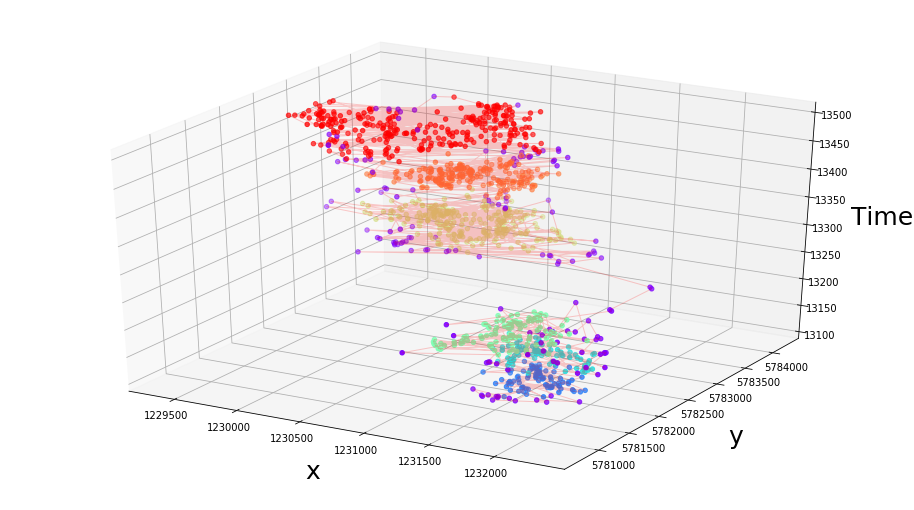

In [95]:
fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection='3d')

xs = [tup[4] for tup in rows]
ys = [tup[5] for tup in rows]
zs = [tup[3] for tup in rows]
ls = [tup[7] for tup in rows]
floatx = [float(x) for x in xs]
floaty = [float(y) for y in ys]


ax.plot(floatx, floaty, zs, c='r', linewidth=1, alpha=0.2)
ax.scatter3D(xs, ys, zs, c=ls, cmap='rainbow')
ax.set_xlabel("x", size=25, labelpad=20)
ax.set_ylabel("y", size=25, labelpad=20)
ax.set_zlabel("Time", size=25, labelpad=20)

***

<br>

### Test with different parameters of DBSCAN algorithm which considers timestamps

Function which saves a 3D plot.

In [96]:
def save_plot(rows, path):
    xs = [tup[4] for tup in rows]
    ys = [tup[5] for tup in rows]
    zs = [tup[3] for tup in rows]
    ls = [tup[7] for tup in rows]

    fig = plt.figure(figsize=(16,9))
    plt.title(path)
    ax = Axes3D(fig)
    ax.scatter(xs, ys, zs, c=ls, cmap="rainbow", s=75)
    ax.set_xlabel("x", size=25, labelpad=20)
    ax.set_ylabel("y", size=25, labelpad=20)
    ax.set_zlabel("Time", size=25, labelpad=20)
    fig.savefig(path)
    plt.close()

<br>
Tests with different parameters.

In [34]:
conn = create_connection()
par_eps = range(260, 420, 20)
par_minPoints = [10, 15, 20]
par_timeDiff = [10, 12, 14, 16, 18]
counter = 1

for eps in par_eps:
    for mPoint in par_minPoints:
        for tDiff in par_timeDiff:
            print("Fig {}: eps {}, minPoints {}, timeDiff {}".format(counter, eps, mPoint, tDiff))
            counter += 1
            l = dbscan_with_time(eps=eps, minPoints=mPoint, timeDiff=tDiff, conn=conn)
            create_table_result_with_time(conn, l)
            rows = get_result_table_rows(conn)
            save_plot(rows, "img/plot_eps{}_mP{}_tD{}".format(eps, mPoint, tDiff))

Fig 1: eps 260, minPoints 10, timeDiff 10
Fig 2: eps 260, minPoints 10, timeDiff 12
Fig 3: eps 260, minPoints 10, timeDiff 14
Fig 4: eps 260, minPoints 10, timeDiff 16
Fig 5: eps 260, minPoints 10, timeDiff 18
Fig 6: eps 260, minPoints 15, timeDiff 10
Fig 7: eps 260, minPoints 15, timeDiff 12
Fig 8: eps 260, minPoints 15, timeDiff 14
Fig 9: eps 260, minPoints 15, timeDiff 16
Fig 10: eps 260, minPoints 15, timeDiff 18
Fig 11: eps 260, minPoints 20, timeDiff 10
Fig 12: eps 260, minPoints 20, timeDiff 12
Fig 13: eps 260, minPoints 20, timeDiff 14
Fig 14: eps 260, minPoints 20, timeDiff 16
Fig 15: eps 260, minPoints 20, timeDiff 18
Fig 16: eps 280, minPoints 10, timeDiff 10
Fig 17: eps 280, minPoints 10, timeDiff 12
Fig 18: eps 280, minPoints 10, timeDiff 14
Fig 19: eps 280, minPoints 10, timeDiff 16
Fig 20: eps 280, minPoints 10, timeDiff 18
Fig 21: eps 280, minPoints 15, timeDiff 10
Fig 22: eps 280, minPoints 15, timeDiff 12
Fig 23: eps 280, minPoints 15, timeDiff 14
Fig 24: eps 280, min

<br>
Some interesting results.

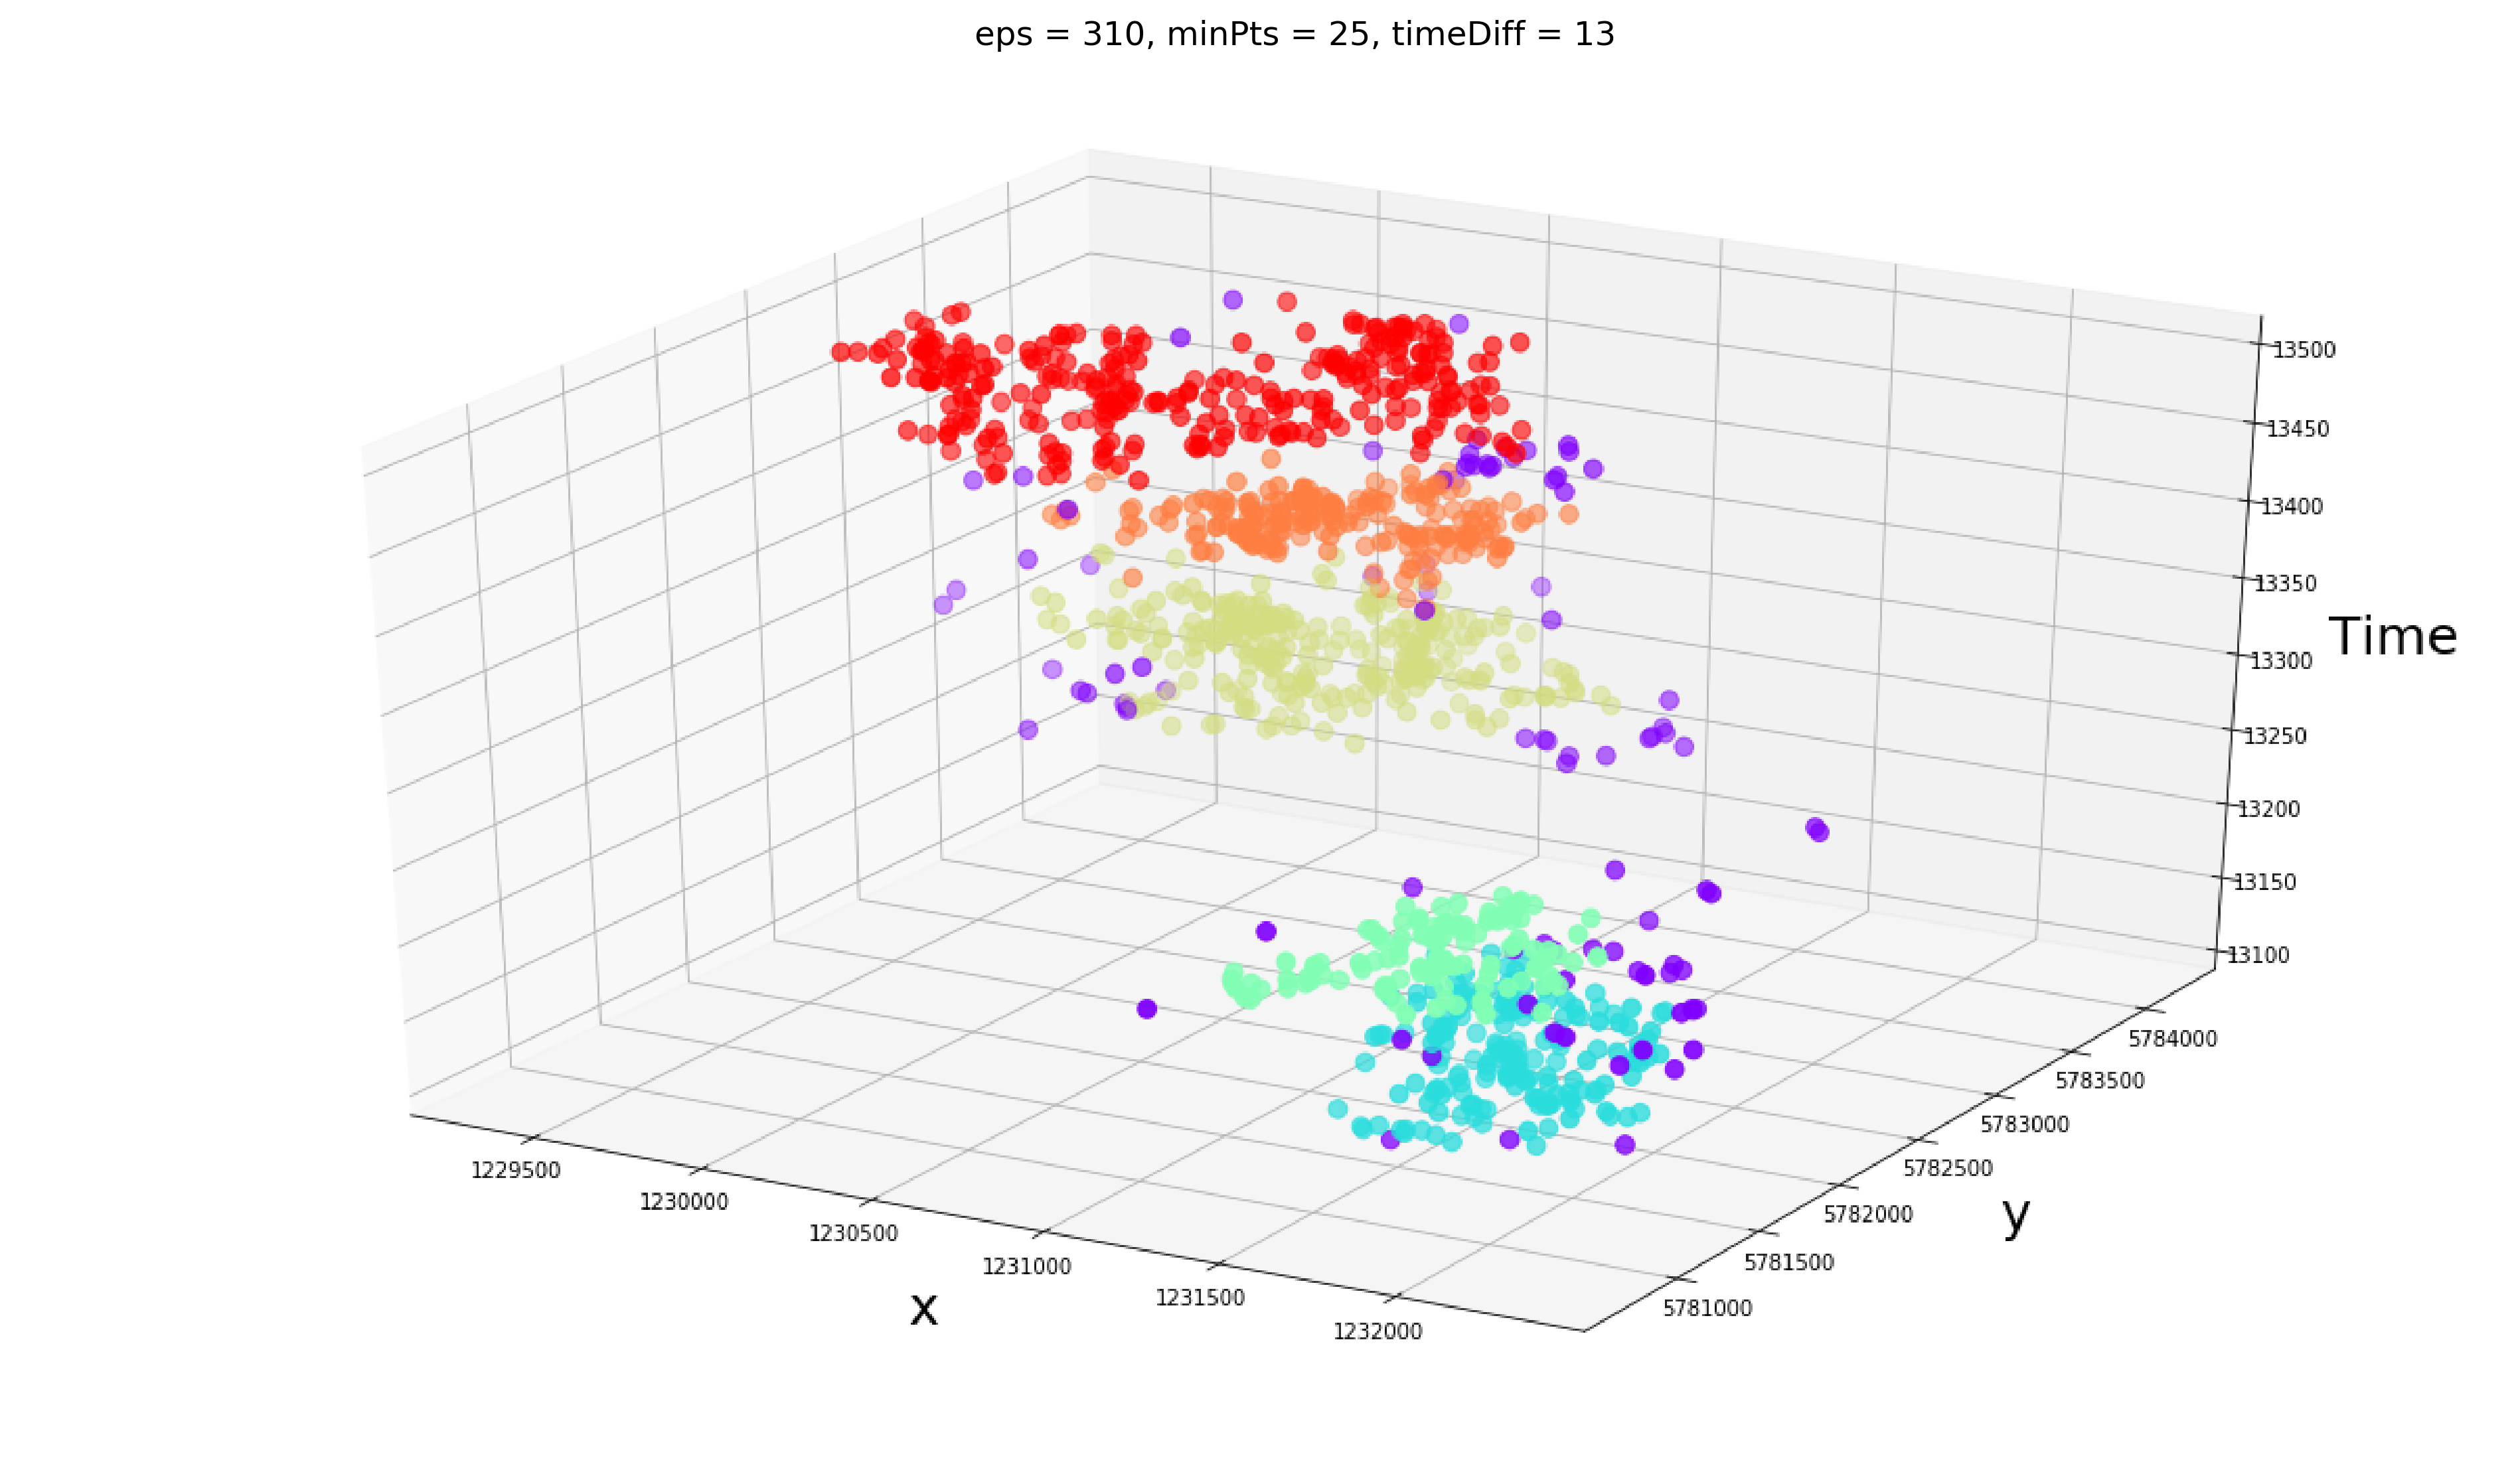

In [97]:
img=mpimg.imread('img/plot_eps310_mP25_tD13.png')
plt.figure(figsize=(16,9), dpi=300)
plt.axis('off')
plt.title("eps = 310, minPts = 25, timeDiff = 13")
plt.imshow(img)

We obtain similar results (two big clusters) if we
1. increase timeDiff (from 13 to 18) or
2. increase eps (from 310 to 400) or
3. decrease minPts (from 25 to 15).

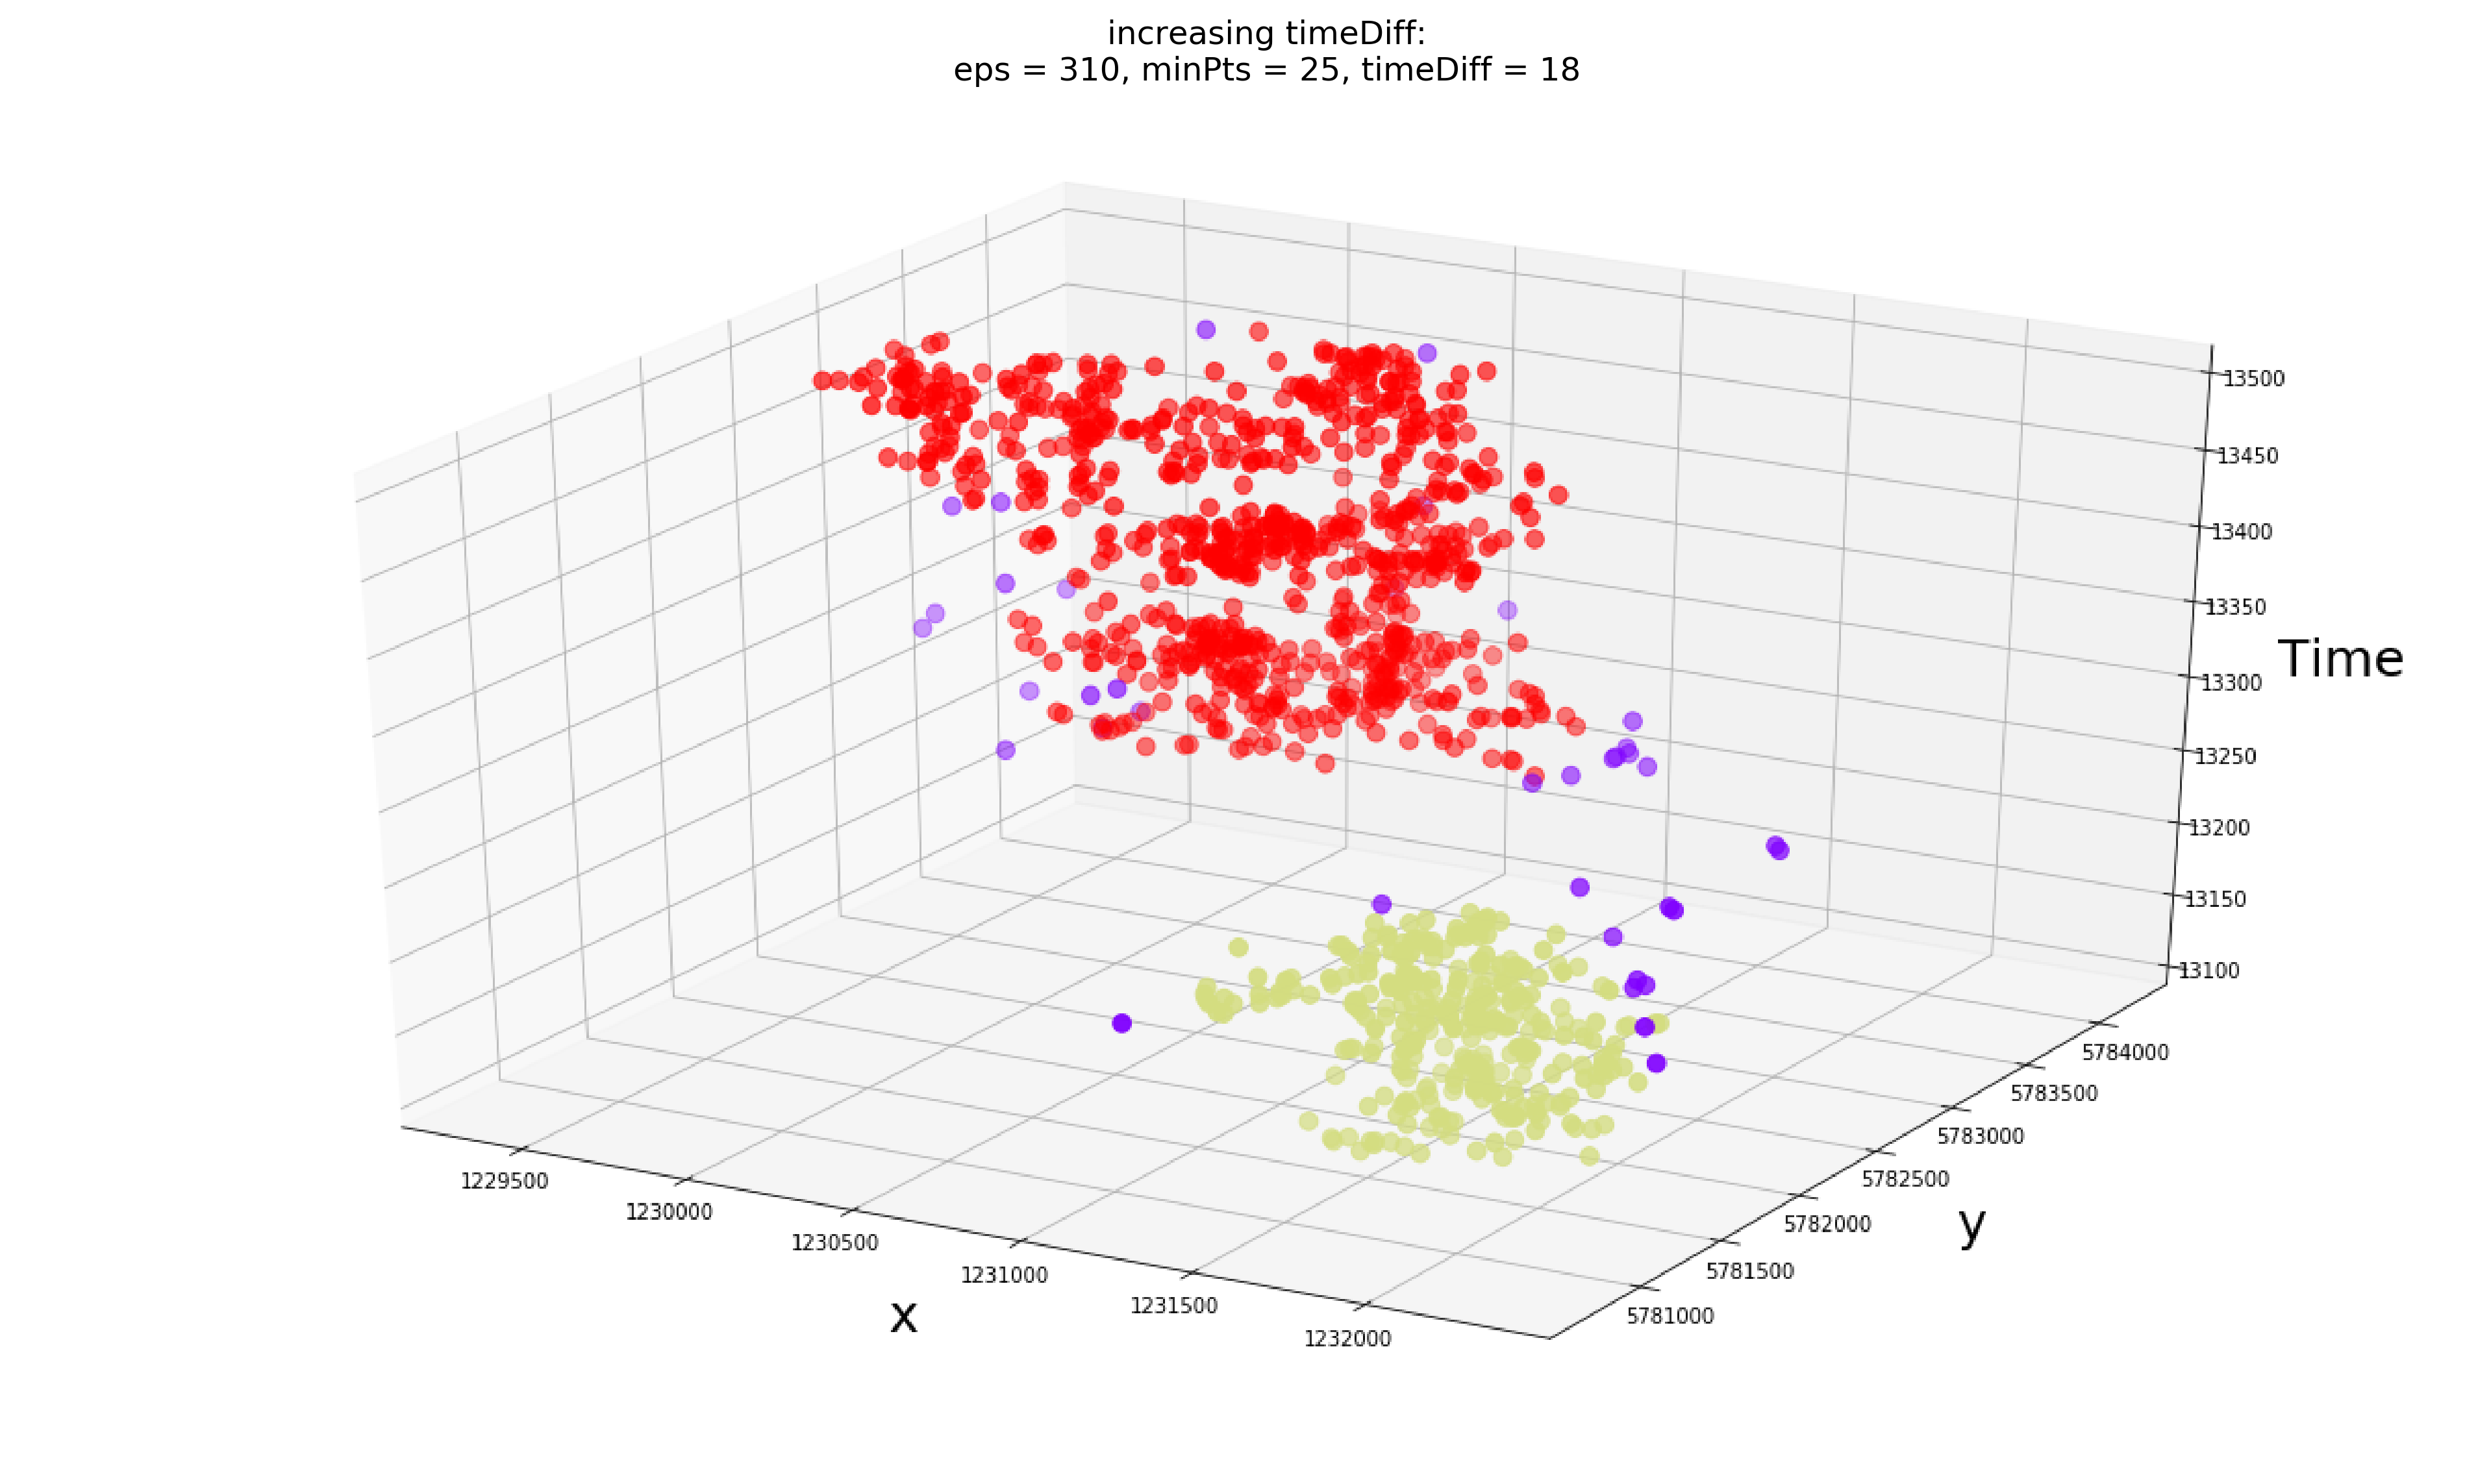

In [98]:
img=mpimg.imread('img/plot_eps310_mP25_tD18.png')
plt.figure(figsize=(16,9), dpi=300)
plt.axis('off')
plt.title("increasing timeDiff:\neps = 310, minPts = 25, timeDiff = 18")
plt.imshow(img)

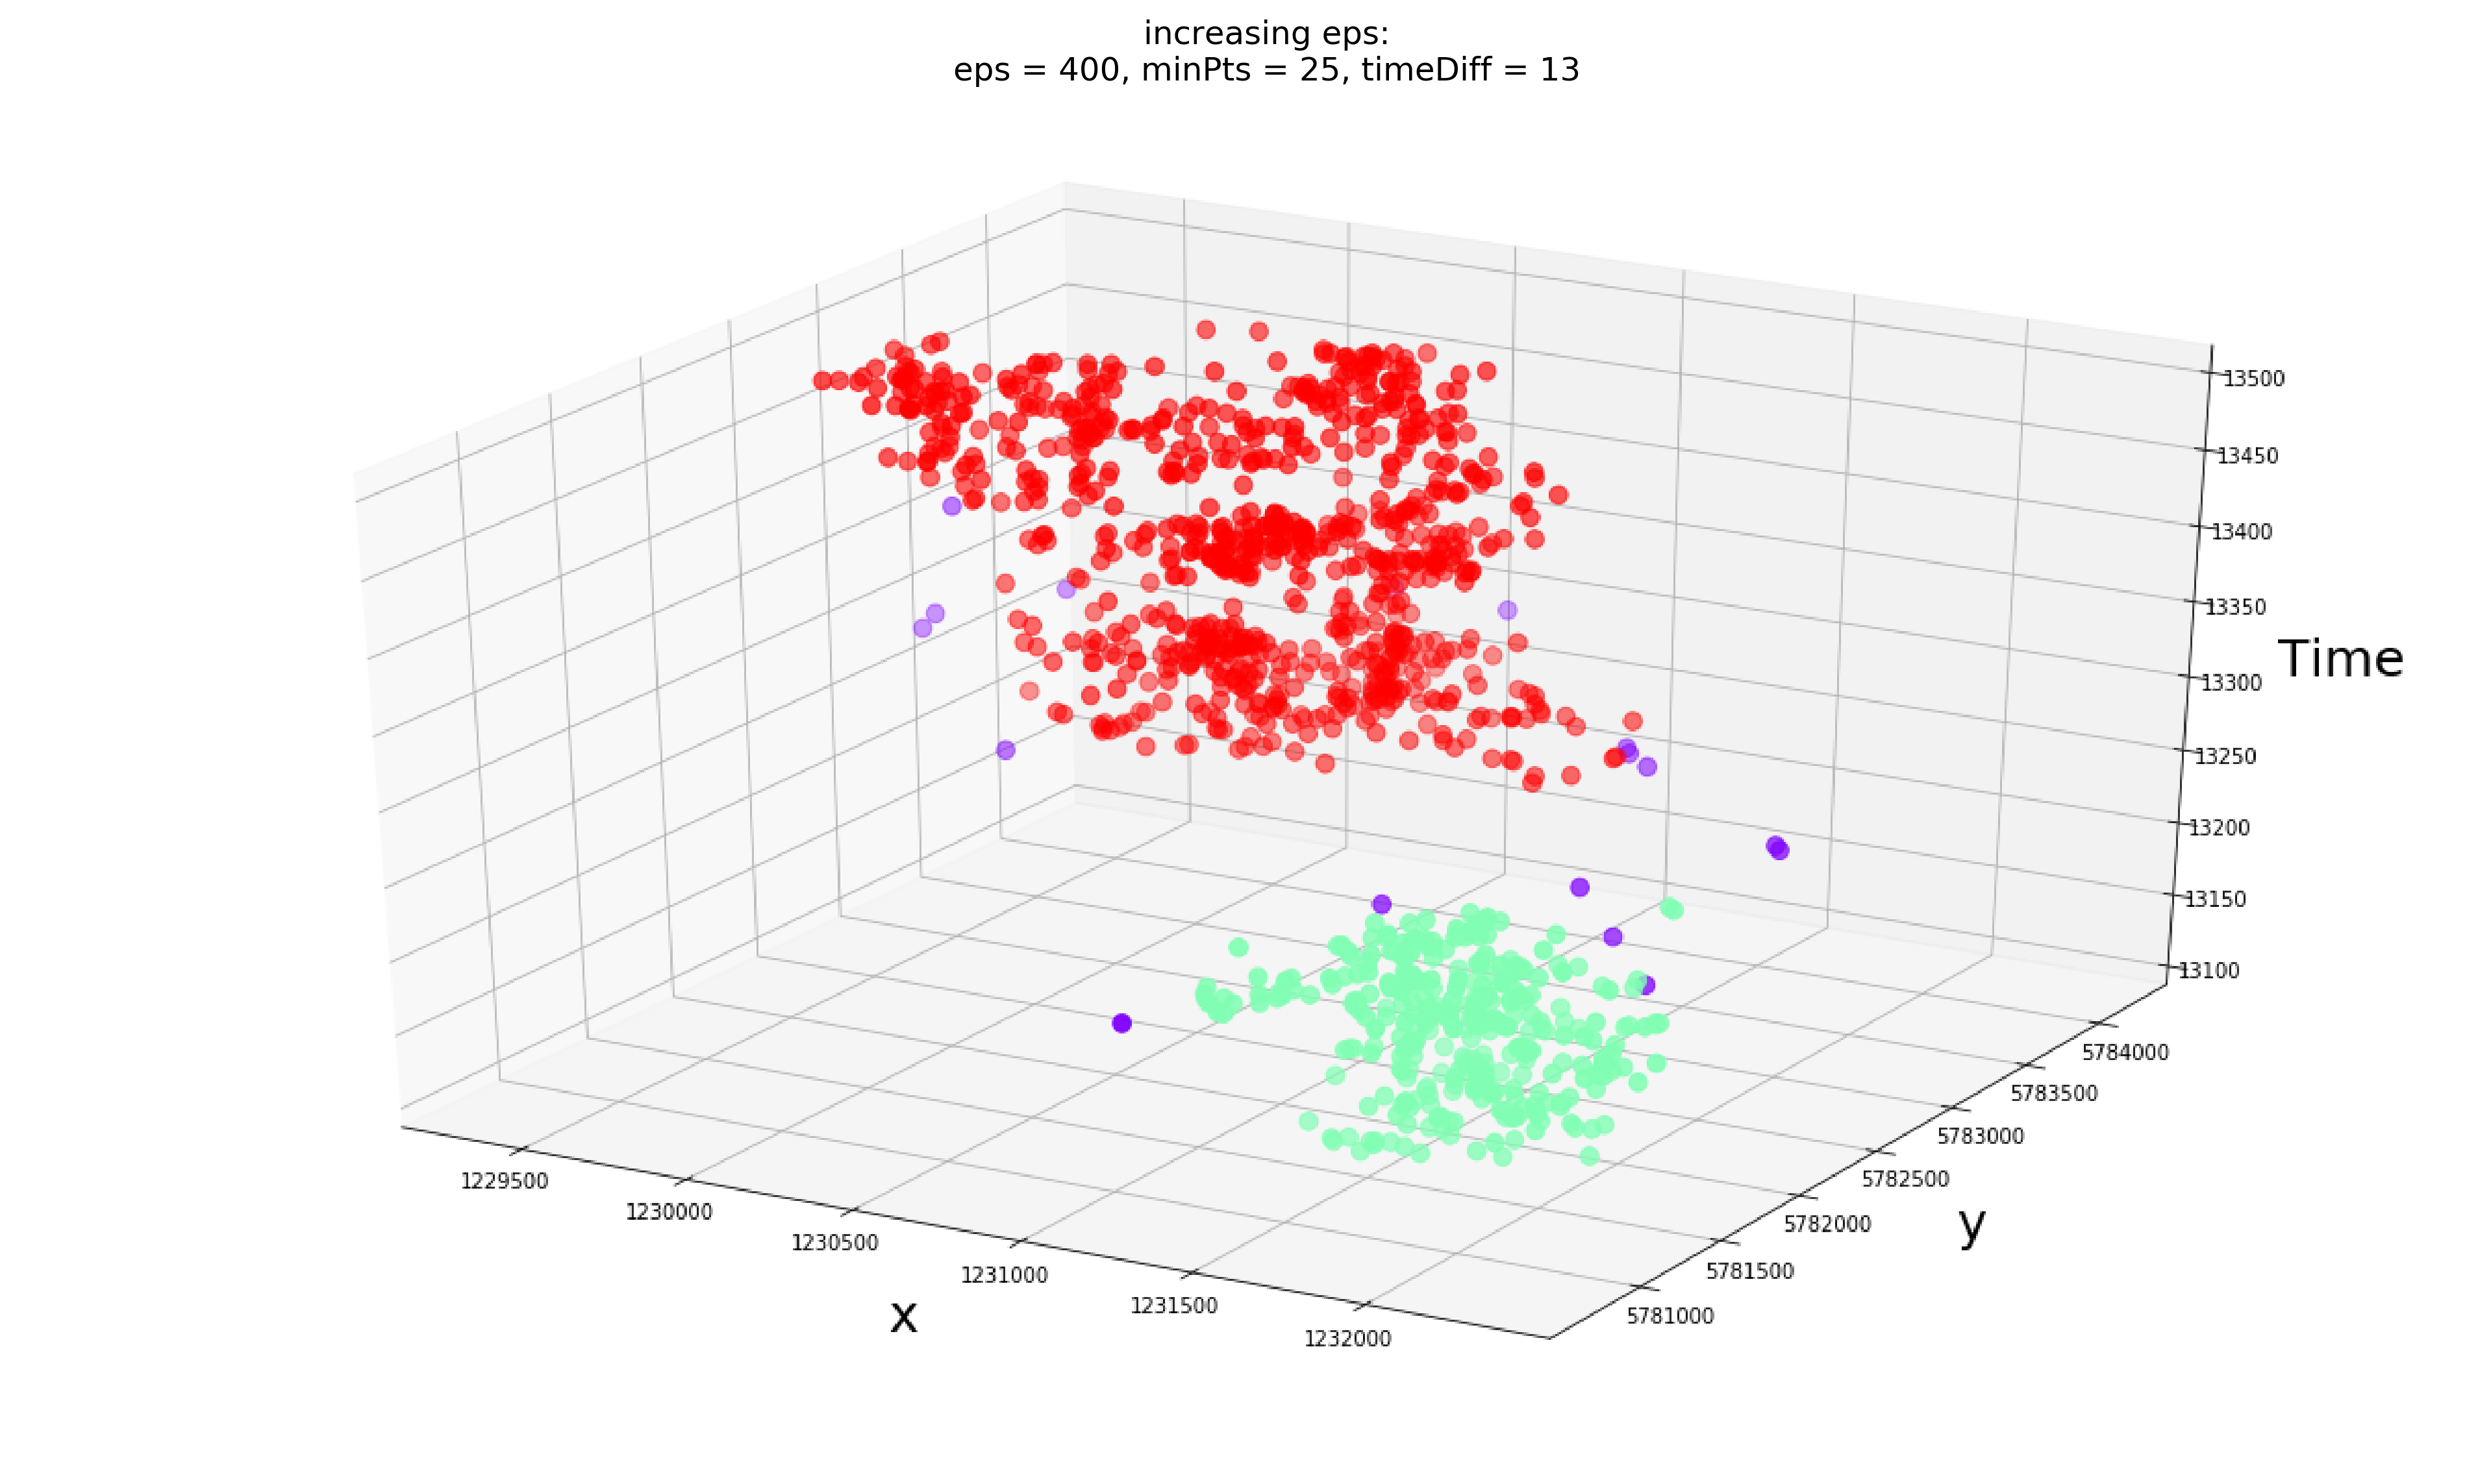

In [99]:
img=mpimg.imread('img/plot_eps400_mP25_tD13.png')
plt.figure(figsize=(16,9), dpi=300)
plt.axis('off')
plt.title("increasing eps:\neps = 400, minPts = 25, timeDiff = 13")
plt.imshow(img)

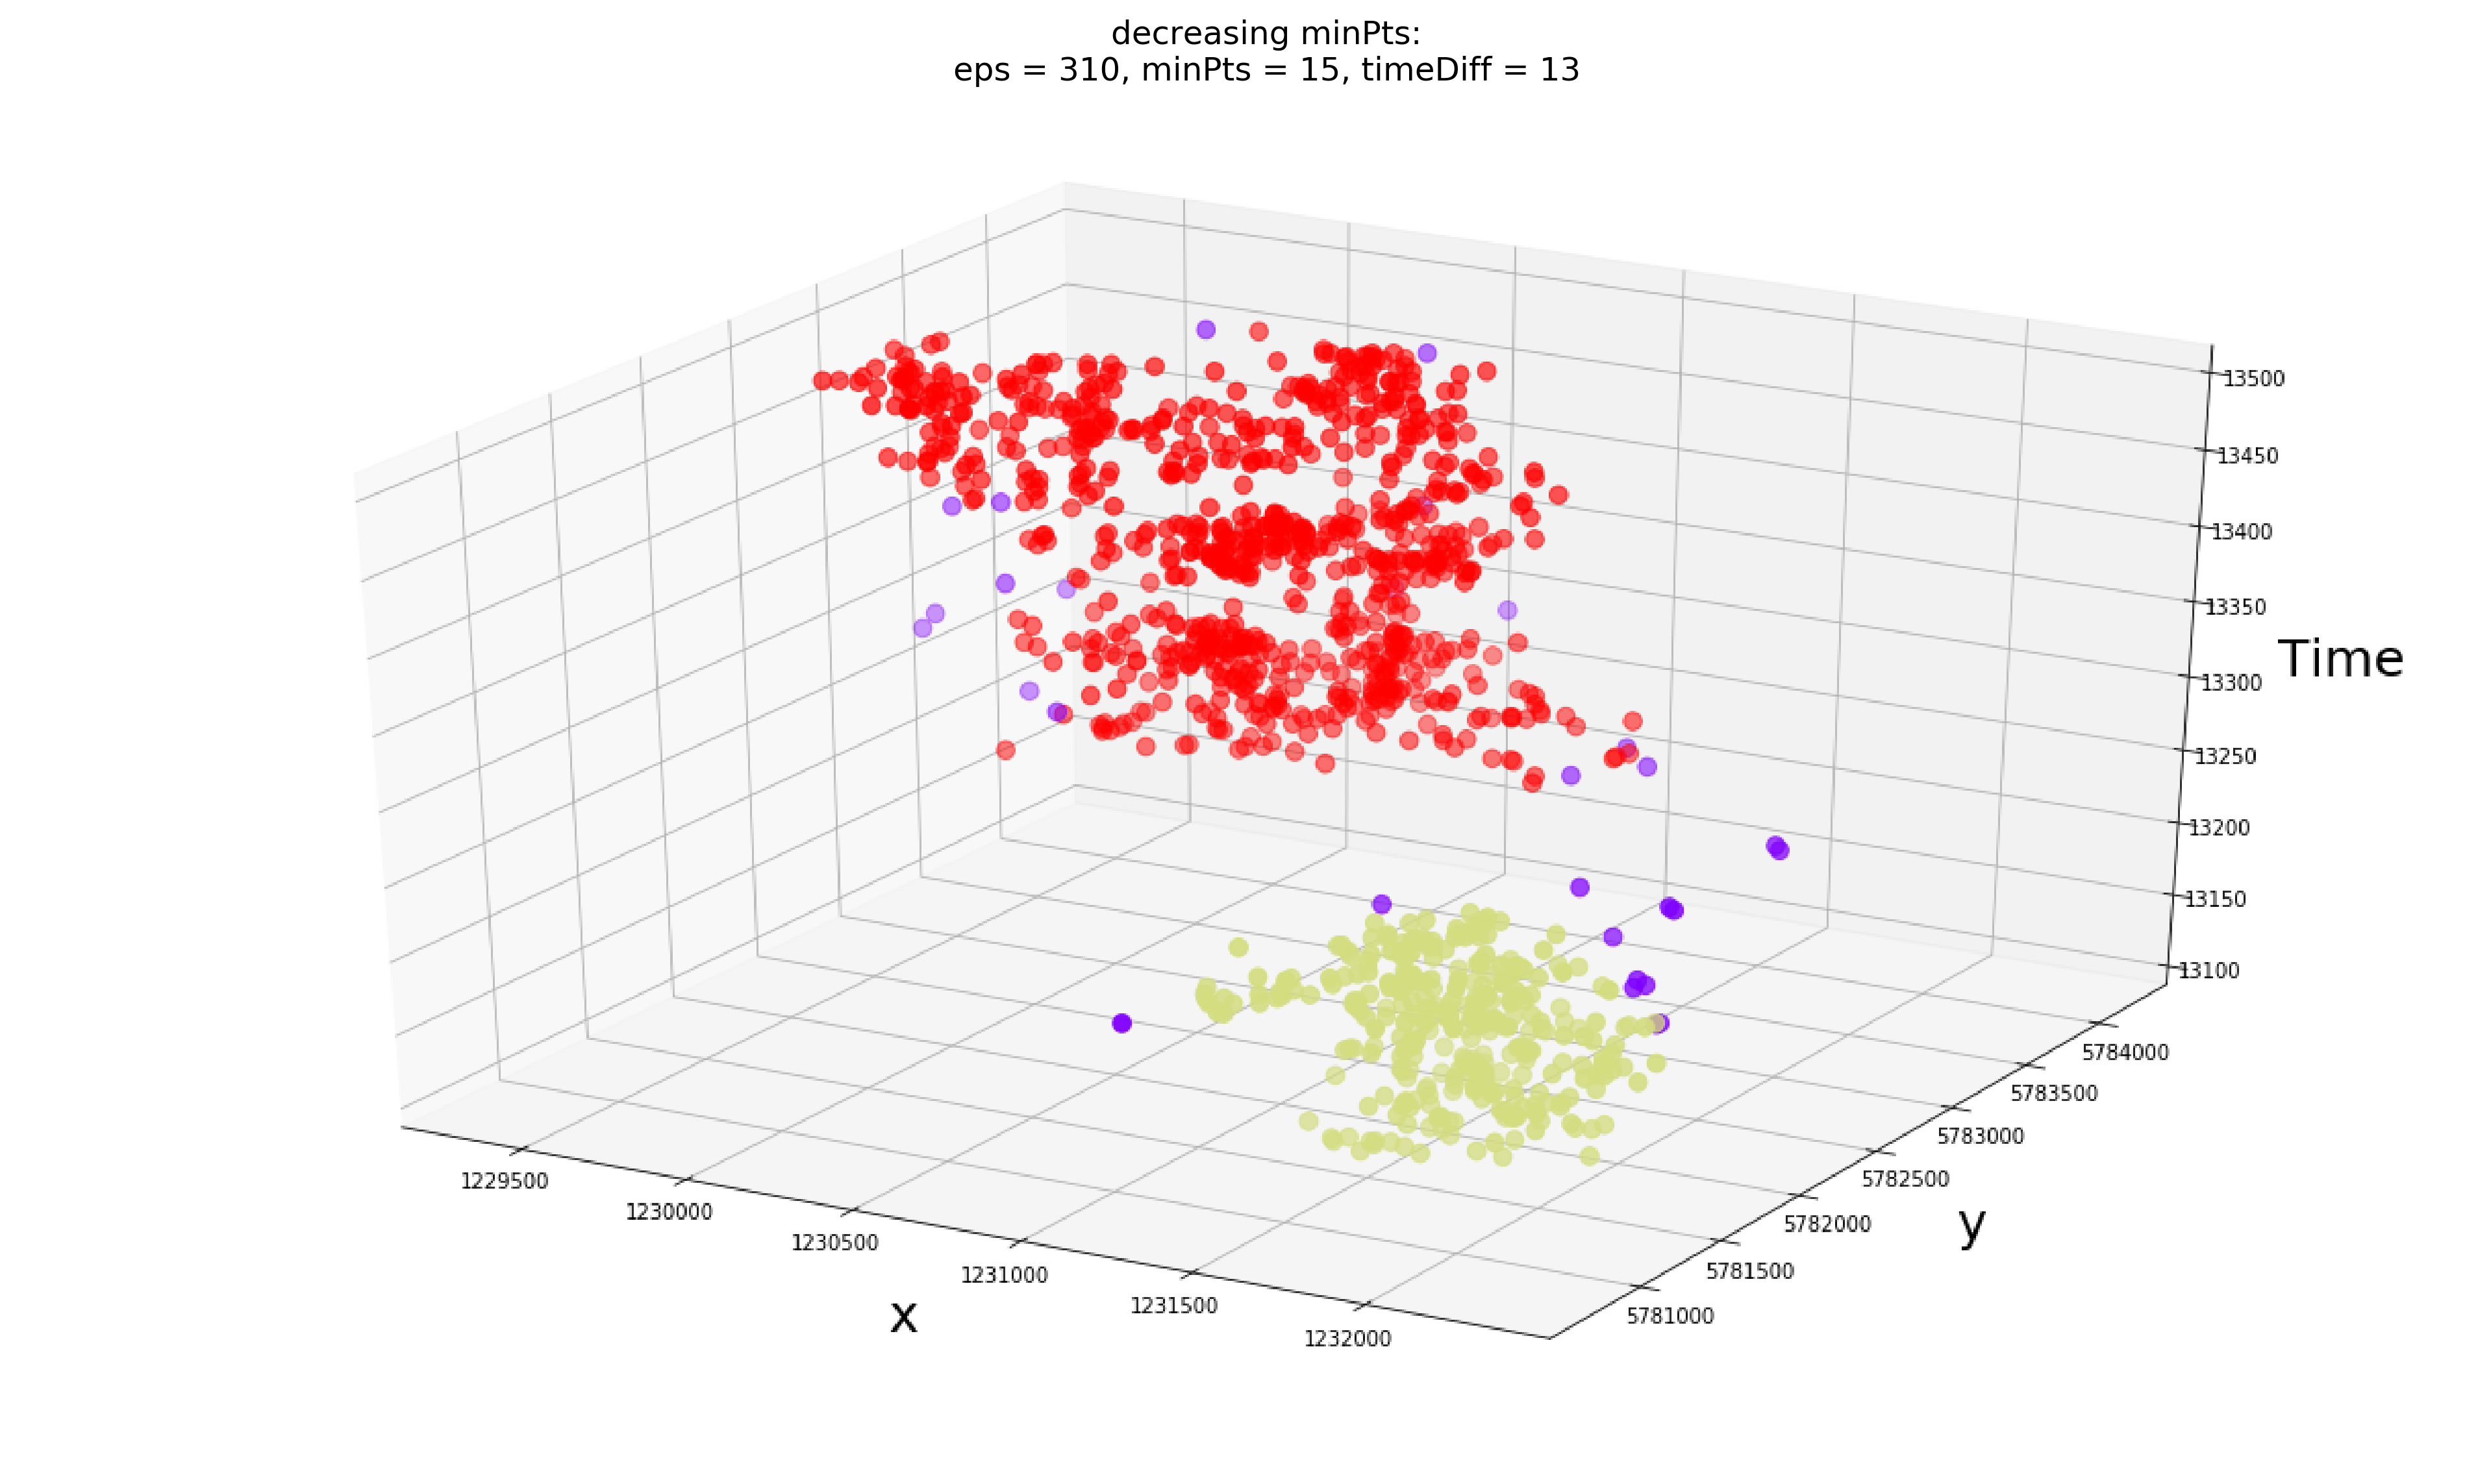

In [100]:
img=mpimg.imread('img/plot_eps310_mP15_tD13.png')
plt.figure(figsize=(16,9), dpi=300)
plt.axis('off')
plt.title("decreasing minPts:\neps = 310, minPts = 15, timeDiff = 13")
plt.imshow(img)

<br>
Interactive.

In [101]:
import numpy as np
import matplotlib.image as mpimg

def images_slider(eps, minPts, timeDiff):
    img=mpimg.imread('img/plot_eps{}_mP{}_tD{}.png'.format(eps, minPts, timeDiff))
    plt.figure(figsize=(16,9), dpi=300)
    plt.axis('off')
    plt.title("eps = {}, minPts = {}, timeDiff = {}".format(eps, minPts, timeDiff))
    plt.imshow(img)

In [102]:
from ipywidgets import interact, widgets

a_slider = widgets.IntSlider(min=300, max=360, step=20, value=320)
b_slider = widgets.IntSlider(min=10, max=25, step=5, value=15)
c_slider = widgets.IntSlider(min=8, max=18, step=2, value=14)
w = widgets.interactive(images_slider, eps=a_slider, minPts=b_slider, timeDiff=c_slider)
display(w)

interactive(children=(IntSlider(value=320, description='eps', max=360, min=300, step=20), IntSlider(value=15, …

Other results.

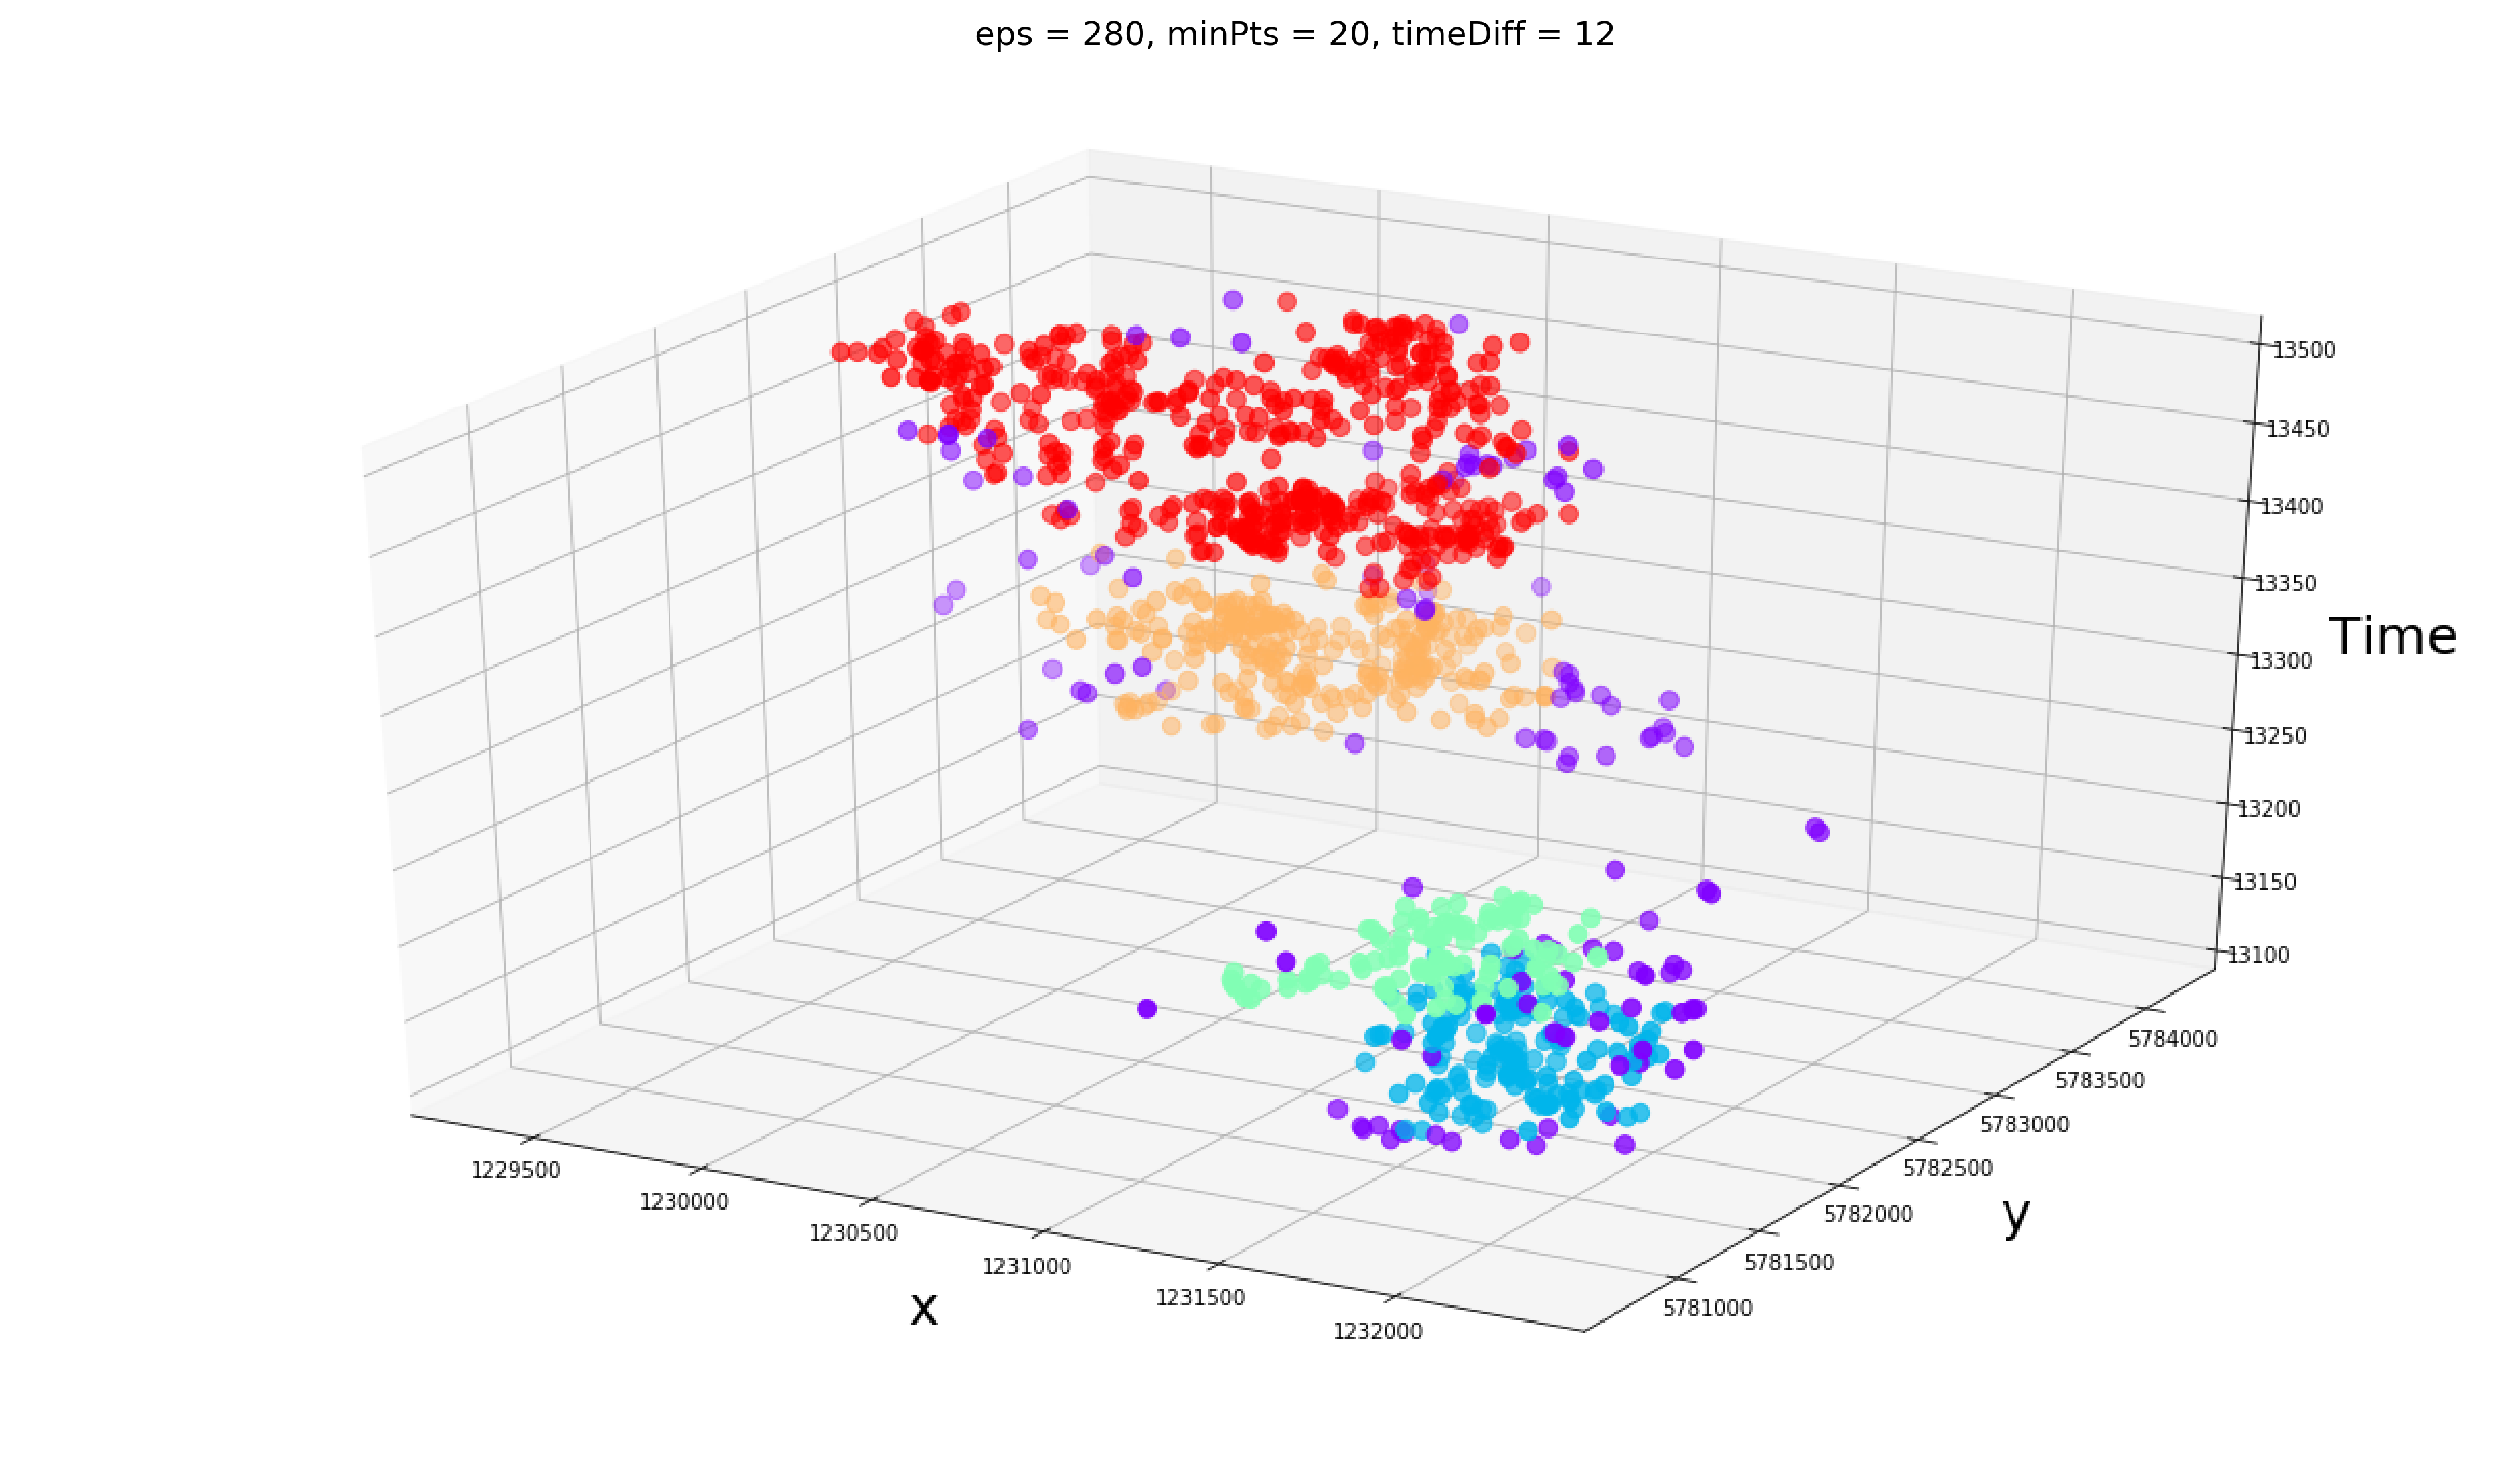

In [103]:
img=mpimg.imread('img/plot_eps280_mP20_tD12.png')
plt.figure(figsize=(16,9), dpi=300)
plt.axis('off')
plt.title("eps = 280, minPts = 20, timeDiff = 12")
plt.imshow(img)

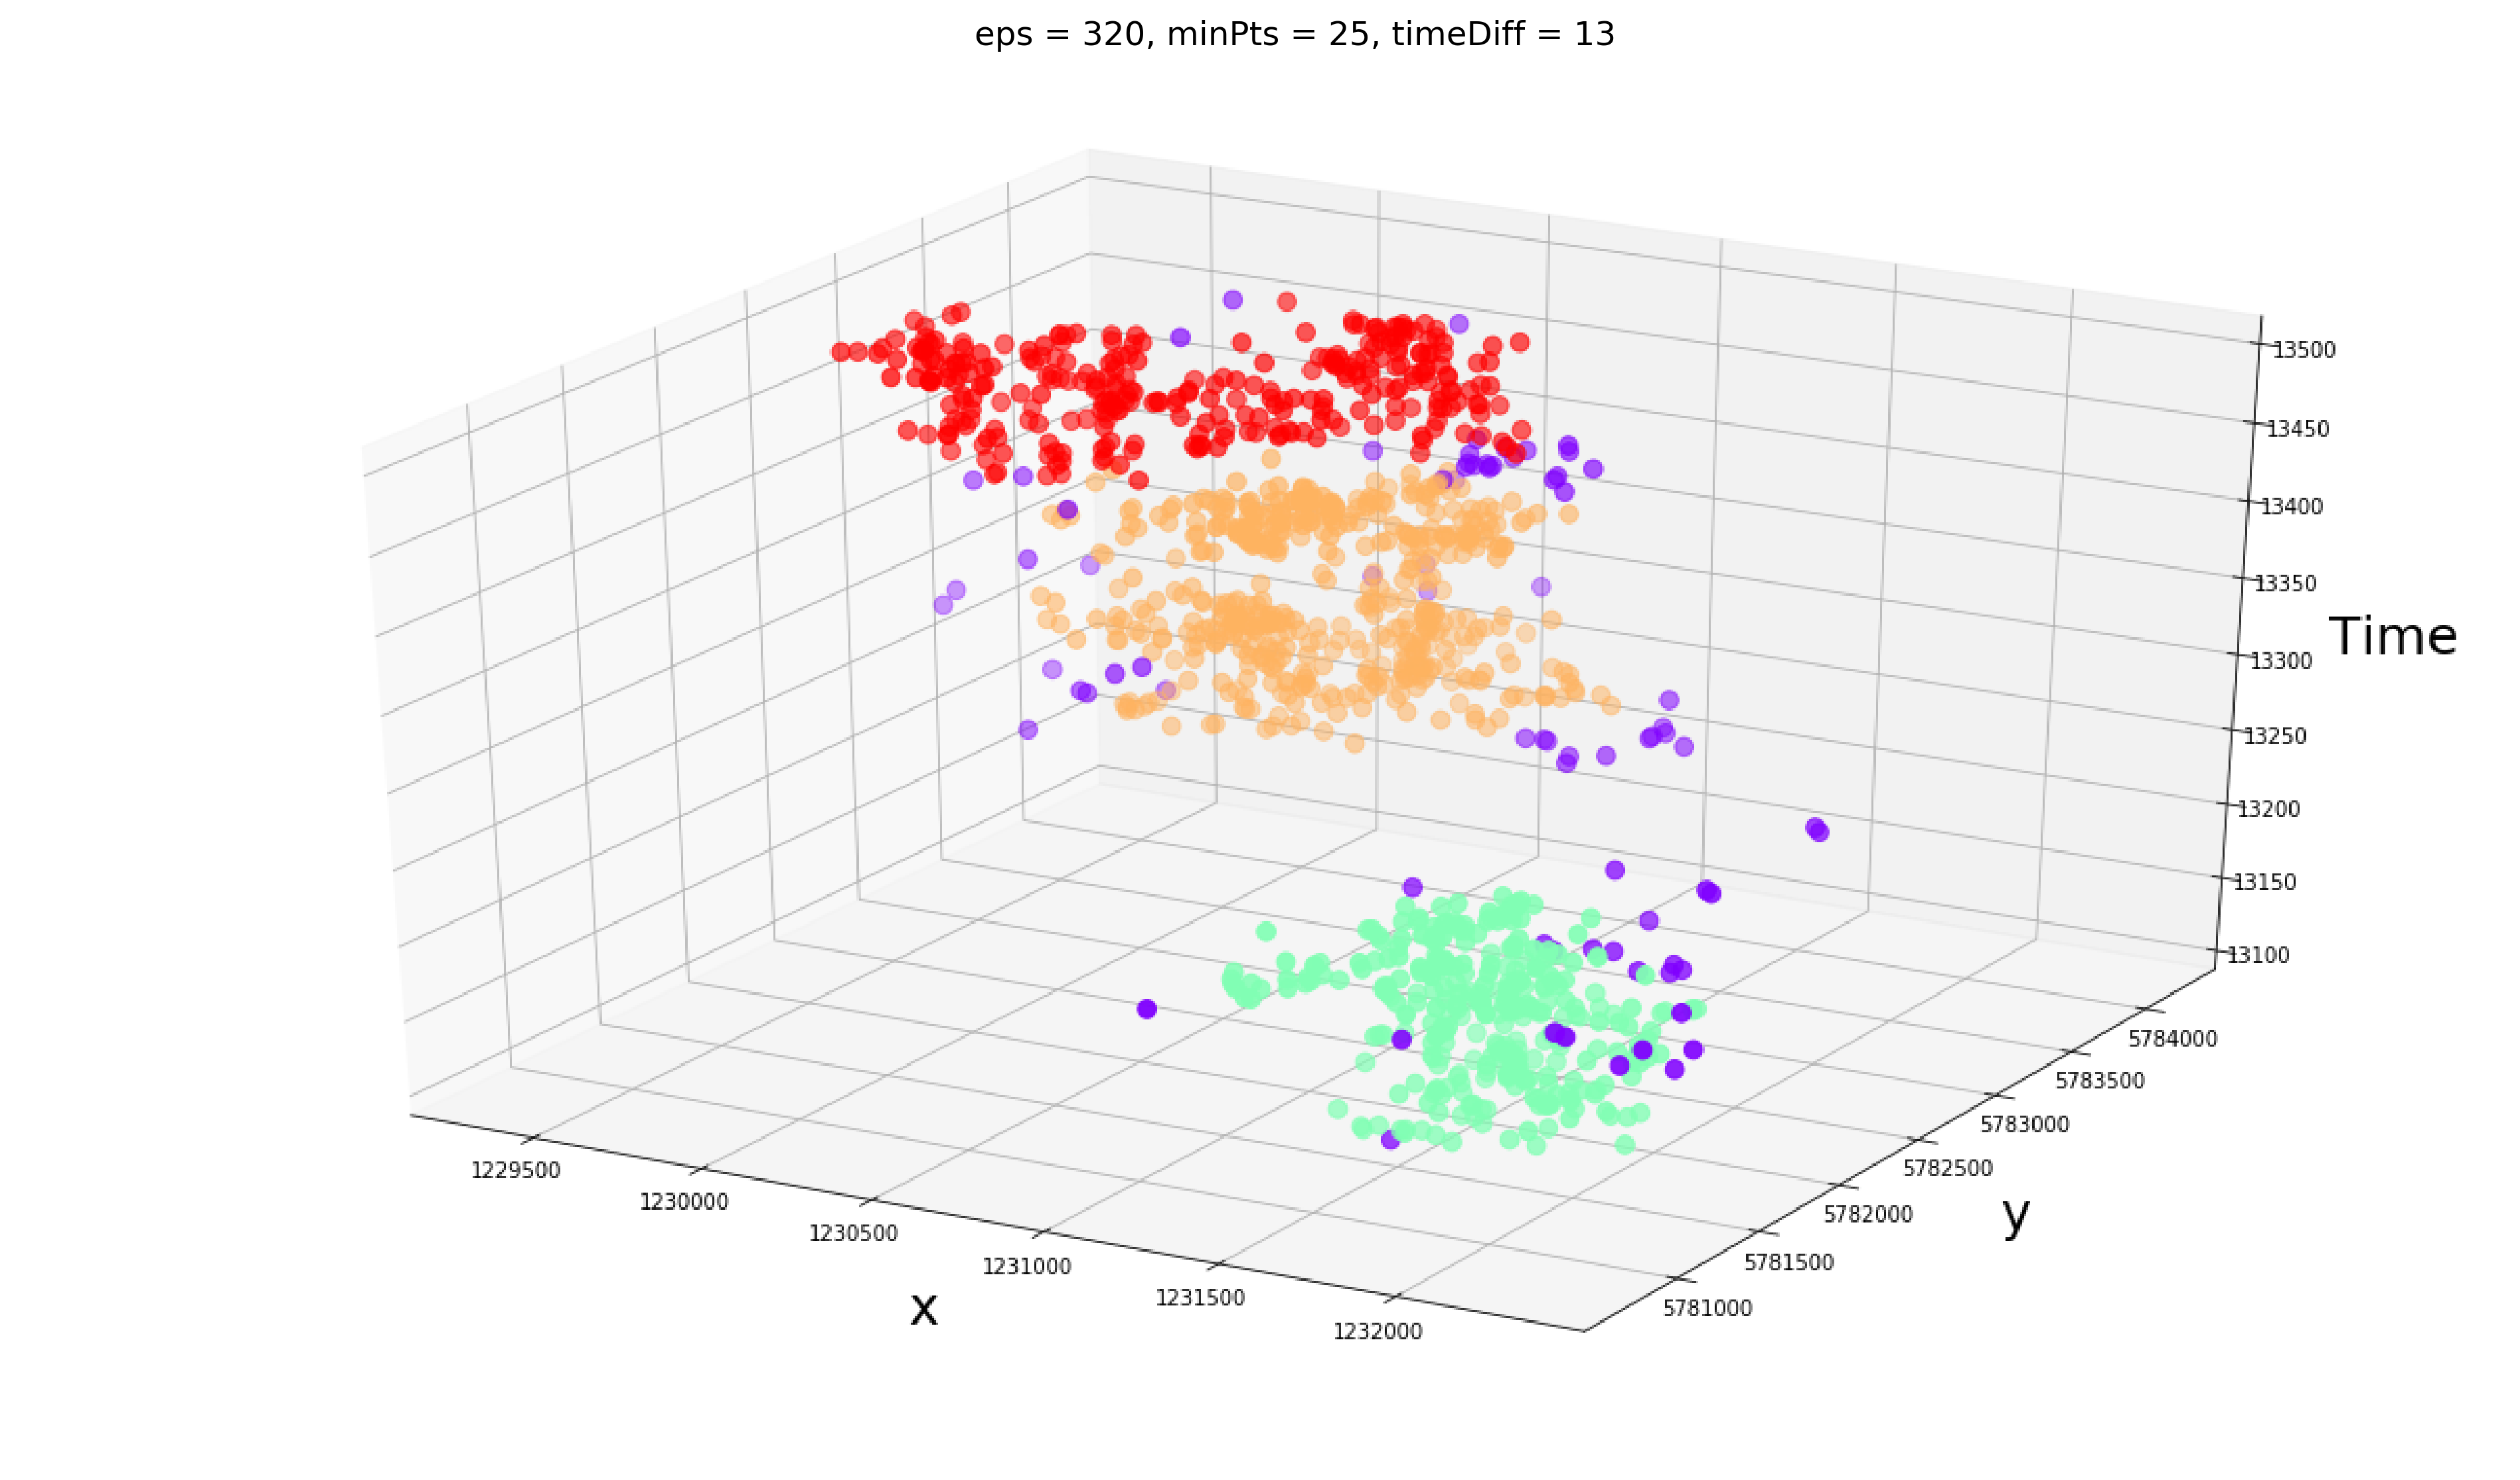

In [104]:
img=mpimg.imread('img/plot_eps320_mP25_tD13.png')
plt.figure(figsize=(16,9), dpi=300)
plt.axis('off')
plt.title("eps = 320, minPts = 25, timeDiff = 13")
plt.imshow(img)